# Object CXR baseline result

This notebook demonstrates a baseline object detection method for foreign object detection. `engine.py` and `utils.py` were modified from [torchvision object detection reference training scripts](https://github.com/pytorch/vision/tree/master/references/detection).

Please find all dependencies in `requirements.txt` to run this notebook.

In [1]:
import torch
import torchvision
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import utils

from PIL import Image, ImageDraw
from engine import train_one_epoch
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tqdm import tqdm

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [5]:
OBJECT_SEP = ';'
ANNOTATION_SEP = ' '

# ─── DATA_DIR
#     ├── train
#     │   ├── #####.jpg
#     │   └── ...
#     ├── dev
#     │   ├── #####.jpg
#     │   └── ...
#     ├── train.csv
#     └── dev.csv
data_dir = 'data/'

device = torch.device('cpu')
num_classes = 2  # object (foreground); background

In [7]:
def draw_annotation(im, anno_str, fill=(255, 63, 63, 40)):
    draw = ImageDraw.Draw(im, mode="RGBA")
    for anno in anno_str.split(OBJECT_SEP):
        anno = list(map(int, anno.split(ANNOTATION_SEP)))
        if anno[0] == 0:
            draw.rectangle(anno[1:], fill=fill)
        elif anno[0] == 1:
            draw.ellipse(anno[1:], fill=fill)
        else:
            draw.polygon(anno[1:], fill=fill)

## Data

8000 pictures in data/train/
1000 pictures in data/dev/


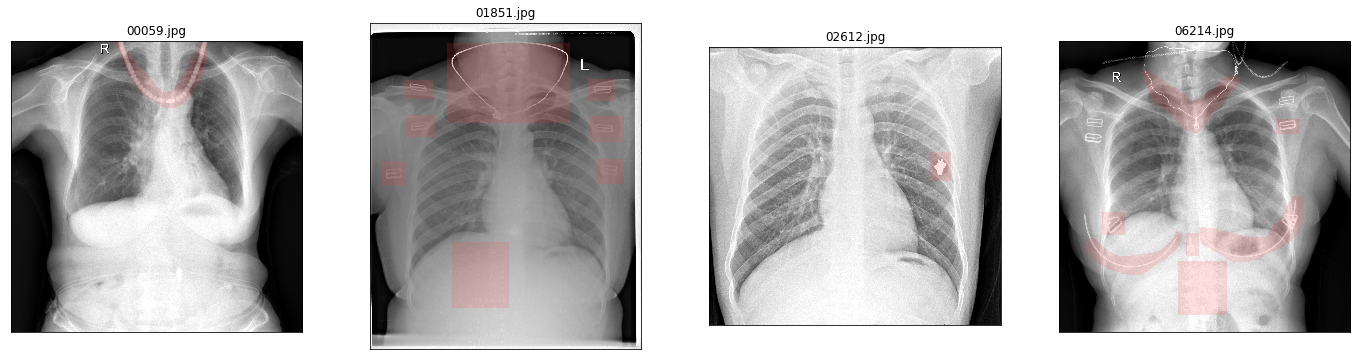

In [8]:
labels_tr = pd.read_csv(data_dir + 'train.csv', na_filter=False)
labels_dev = pd.read_csv(data_dir + 'dev.csv', na_filter=False)

print(f'{len(os.listdir(data_dir + "train"))} pictures in {data_dir}train/')
print(f'{len(os.listdir(data_dir + "dev"))} pictures in {data_dir}dev/')
# print(f'{len(os.listdir(data_dir + "test"))} pictures in {data_dir}test/')

# viz
fig, axs = plt.subplots(
    nrows=1, ncols=4, subplot_kw=dict(xticks=[], yticks=[]), figsize=(24, 6)
)

example_idxes = [58, 1850, 2611, 6213]
for row, ax in zip(
    labels_tr.iloc[example_idxes].itertuples(index=False), axs
):
    im = Image.open(data_dir + "train/" + row.image_name).convert("RGB")
    if row.annotation:
        draw_annotation(im, row.annotation)
    
    ax.imshow(im)
    ax.set_title(f"{row.image_name}")

## Build Dataset

In [9]:
labels_tr = labels_tr.loc[labels_tr['annotation'].astype(bool)].reset_index(drop=True)
img_class_dict_tr = dict(zip(labels_tr.image_name, labels_tr.annotation))
img_class_dict_dev = dict(zip(labels_dev.image_name, labels_dev.annotation))

In [10]:
class ForeignObjectDataset(object):
    
    def __init__(self, datafolder, datatype='train', transform = True, labels_dict={}):
        self.datafolder = datafolder
        self.datatype = datatype
        self.labels_dict = labels_dict
        self.image_files_list = [s for s in sorted(os.listdir(datafolder)) if s in labels_dict.keys()]
        self.transform = transform
        self.annotations = [labels_dict[i] for i in self.image_files_list]
            
    def __getitem__(self, idx):
        # load images 
        img_name = self.image_files_list[idx]
        img_path = os.path.join(self.datafolder, img_name)
        img = Image.open(img_path).convert("RGB")
        width, height = img.size[0],img.size[1]  
        
        if self.datatype == 'train':
            annotation = self.labels_dict[img_name]
            
            boxes = []
            
            if type(annotation) == str:
                annotation_list = annotation.split(';')
                for anno in annotation_list:
                    x = []
                    y = []
                
                    anno = anno[2:]
                    anno = anno.split(' ')
                    for i in range(len(anno)):
                        if i % 2 == 0:
                            x.append(float(anno[i]))
                        else:
                            y.append(float(anno[i]))
                        
                    xmin = min(x)/width * 600
                    xmax = max(x)/width * 600
                    ymin = min(y)/height * 600
                    ymax = max(y)/height * 600
                    boxes.append([xmin, ymin, xmax, ymax])

            # convert everything into a torch.Tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            # there is only one class
            labels = torch.ones((len(boxes),), dtype=torch.int64)

            image_id = torch.tensor([idx])
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            # suppose all instances are not crowd
            iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["image_id"] = image_id
            target["area"] = area
            target["iscrowd"] = iscrowd
            
            if self.transform is not None:
                img = self.transform(img)
                
            return img, target
        
        if self.datatype == 'dev':
            
            if self.labels_dict[img_name] == '':
                label = 0
            else:
                label = 1
            
            if self.transform is not None:
                img = self.transform(img)

            return img, label, width, height

        

    def __len__(self):
        return len(self.image_files_list)

In [11]:
import torchvision.transforms as transforms

data_transforms = transforms.Compose([
    transforms.Resize((600,600)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

dataset_train = ForeignObjectDataset(datafolder= data_dir + 'train/', datatype='train', transform=data_transforms, labels_dict=img_class_dict_tr)
dataset_dev = ForeignObjectDataset(datafolder= data_dir + 'dev/', datatype='dev', transform=data_transforms, labels_dict=img_class_dict_dev)

In [12]:
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=8, shuffle= True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    dataset_dev, batch_size=1, shuffle= False, num_workers=4,
    collate_fn=utils.collate_fn)

## Training

In [13]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def _get_detection_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
model_ft = _get_detection_model(num_classes)
model_ft.to(device)

params = [p for p in model_ft.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.1)

num_epochs = 7

auc_max = 0

for epoch in range(num_epochs):
    
    train_one_epoch(model_ft, optimizer, data_loader, device, epoch, print_freq=20)
    
    lr_scheduler.step()
    
    model_ft.eval()
    val_pred = []
    val_label = []
    for batch_i, (image, label,  width, height) in enumerate(data_loader_val):
        image = list(img.to(device) for img in image)
        
        val_label.append(label[-1])

        outputs = model_ft(image)
        if len(outputs[-1]['boxes']) == 0:
            val_pred.append(0)
        else:
            val_pred.append(torch.max(outputs[-1]['scores']).tolist())
    
    val_pred_label = []
    for i in range(len(val_pred)):
        if val_pred[i] >= 0.5:
            val_pred_label.append(1)
        else:
            val_pred_label.append(0)
            
    number = 0
    
    for i in range(len(val_pred_label)):
        if val_pred_label[i] == val_label[i]:
            number += 1
    acc = number / len(val_pred_label)
    
    auc = roc_auc_score(val_label,val_pred)
    print('Epoch: ', epoch, '| val acc: %.4f' % acc, '| val auc: %.4f' % auc)
    
    if auc > auc_max:
        auc_max = auc
        print('Best Epoch: ', epoch, '| val acc: %.4f' % acc, '| Best val auc: %.4f' % auc_max)
        torch.save(model_ft.state_dict(), "model.pt")
    

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/ubuntu/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428091666/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Epoch: [0]  [  0/500]  eta: 16:22:26  lr: 0.000015  loss: 2.1486 (2.1486)  loss_classifier: 1.5319 (1.5319)  loss_box_reg: 0.0053 (0.0053)  loss_objectness: 0.5910 (0.5910)  loss_rpn_box_reg: 0.0205 (0.0205)  time: 117.8921


## Evaluation

In [12]:
model = _get_detection_model(num_classes)
model.to(device)
model.load_state_dict(torch.load("model.pt"))

model.eval()

preds = []
labels = []
locs = []

for image, label, width, height in tqdm(data_loader_val):
    
    image = list(img.to(device) for img in image)
    labels.append(label[-1])
    
    outputs = model(image)
    
    center_points = []
    center_points_preds = []
    
    if len(outputs[-1]['boxes']) == 0:
        preds.append(0)
        center_points.append([])
        center_points_preds.append('')
        locs.append('')
    else:
        preds.append(torch.max(outputs[-1]['scores']).tolist())
        
        new_output_index = torch.where((outputs[-1]['scores']>0.1))
        new_boxes = outputs[-1]['boxes'][new_output_index]
        new_scores = outputs[-1]['scores'][new_output_index]
        
        for i in range(len(new_boxes)):
            new_box = new_boxes[i].tolist()
            center_x = (new_box[0] + new_box[2])/2
            center_y = (new_box[1] + new_box[3])/2
            center_points.append([center_x/600 * width[-1],center_y/600 * height[-1]])
        center_points_preds += new_scores.tolist()
        
        line = ''
        for i in range(len(new_boxes)):
            if i == len(new_boxes)-1:
                line += str(center_points_preds[i]) + ' ' + str(center_points[i][0]) + ' ' + str(center_points[i][1])
            else:
                line += str(center_points_preds[i]) + ' ' + str(center_points[i][0]) + ' ' + str(center_points[i][1]) +';'
        locs.append(line)

cls_res = pd.DataFrame({'image_name': dataset_dev.image_files_list, 'prediction': preds})
cls_res.to_csv('classification.csv', columns=['image_name', 'prediction'], sep=',', index=None)
print('classification.csv generated.')

loc_res = pd.DataFrame({'image_name': dataset_dev.image_files_list, 'prediction': locs})
loc_res.to_csv('localization.csv', columns=['image_name', 'prediction'], sep=',', index=None)
print('localization.csv generated.')

100%|██████████| 1000/1000 [00:54<00:00, 18.36it/s]

classification.csv generated.
localization.csv generated.


### Calculate ACC and AUC

In [13]:
pred = cls_res.prediction.values
gt = labels_dev.annotation.astype(bool).astype(float).values

In [14]:
acc = ((pred >= .5) == gt).mean()
fpr, tpr, _ = roc_curve(gt, pred)
roc_auc = auc(fpr, tpr)

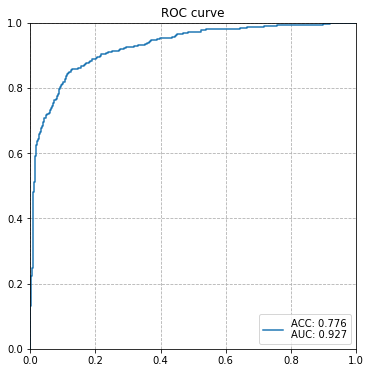

In [15]:
fig, ax = plt.subplots(
    subplot_kw=dict(xlim=[0, 1], ylim=[0, 1], aspect='equal'),
    figsize=(6, 6)
)
ax.plot(fpr, tpr, label=f'ACC: {acc:.03}\nAUC: {roc_auc:.03}')
_ = ax.legend(loc="lower right")
_ = ax.set_title('ROC curve')
ax.grid(linestyle='dashed')

### Calculate FROC

In [ ]:
!wget "https://raw.githubusercontent.com/jfhealthcare/object-CXR/master/froc.py"

In [16]:
%run froc.py $data_dir"dev.csv" "localization.csv"

False positives per image:
0.125	0.25	0.5	1	2	4	8
Sensitivity:
0.576	0.707	0.798	0.859	0.892	0.892	0.892
FROC:
0.8022519352568613
